# ModelV2
## Object detection non-overlapping cards

In [1]:
!pip -q install ultralytics wandb


In [5]:
from ultralytics import YOLO
from jassair.utils.paths import get_dataset_path, Datasets
import wandb
import time
import torch
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

%matplotlib inline

### Global variable definition

In [7]:
# DATA_DIR = get_dataset_path(Datasets.SWISS)
BATCH_SIZE = 16
NUM_CLASSES = 36

In [8]:
torch.cuda.is_available()

True

Enable W&B logging for Ultralytics in CLI

`yolo settings wandb=True`

Disable Weights & Biases logging

`yolo settings wandb=False`

In [5]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aarfu (aarfu-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Model
We can use a singel YOLO model for both, object detection and classification tasks.

In [6]:
MODEL = YOLO("yolo11n.pt") # YOLOv11 large

## Train
imgsz: yolo resizes the input images to a square image. Since jasscards are not square, yolo resizes the long side to 640 and then scales the shorter side proportionally.

In [7]:
# Hyperparameters
# epochs=50
# imgsz=640 # 640 (default) – Balanced performance; 512 – Faster, lower memory usage, 1280+ – Best accuracy for small details but slower.
# iterations=100 # Number of tuning cycles (higher = better tuning). The model tries different values for lr, momentum, weight decay, etc.

HYPERPARAMETERS = {
    "lr0": 1e-3,        # renamed from "lr" to "lr0"
    "weight_decay": 1e-5,  # renamed from "wd"
    "imgsz": 640,
    "epochs": 100,
}

In [27]:
RUN_NAME = f"yolo11l_s_1to9_36c_novlp_{time.strftime('%y%m%d-%H%M%S')}"

In [9]:
wandb.init(
    entity="jassair",
    project="ModelV2",  # Specify project
    name=RUN_NAME, # Run name
    config=HYPERPARAMETERS,
)

In [12]:
# Model with all tunable hyperparameters
MODEL.train(
    data="/exchange/dspro2/jassair/s_1to9_36c_novlp/data.yaml",
    device=0,
    batch=BATCH_SIZE,
    optimizer="Adam",
    momentum=0.937,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    perspective=0.001,
    flipud=0.1,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    project="jassair",
    name=RUN_NAME,
    patience=10,
    **HYPERPARAMETERS
)


Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/exchange/dspro2/jassair/s_1to9_36c_novlp/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=jassair, name=train22, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /exchange/dspro2/jassair/s_1to9_36c_novlp/train/labels.cache... 3600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3600/3600 [00:00<?, ?it/s]
val: Scanning /exchange/dspro2/jassair/s_1to9_36c_novlp/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to jassair/train22/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=1e-05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to jassair/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.7G     0.6514     0.5812      0.977        167        640:  30%|██▉       | 67/225 [00:18<00:44,  3.56it/s]


KeyboardInterrupt: 

In [ ]:
wandb.finish()

## Finetune on real life images

In [28]:
model = YOLO("jassair/train2/weights/best.pt")

In [29]:
# Freeze backbone layers in the Sequential model
for i, (name, module) in enumerate(model.model.model.named_children()):
    if i <= 8:
        for param in module.parameters():
            param.requires_grad = False

In [31]:
epochs = 50
batch_size = 16

HYPERPARAMETERS = {
    "epochs": epochs,
    "bach_size": batch_size
}

In [32]:
wandb.init(
    entity="jassair",
    project="ModelV2",  # Specify project
    name=RUN_NAME + 'Finetuned', # Run name
    config=HYPERPARAMETERS,
)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aarfu (aarfu-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [33]:
model.train(data='/exchange/dspro2/jassair/r_1to9_36c_novlp/data.yaml', epochs=epochs, batch=batch_size, name=RUN_NAME + 'Finetuned')

New https://pypi.org/project/ultralytics/8.3.109 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
engine/trainer: task=detect, mode=train, model=jassair/train2/weights/best.pt, data=/exchange/dspro2/jassair/r_1to9_36c_novlp/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11l_s_1to9_36c_novlp_250416-172744Finetuned, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False,

train: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp/train/labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 1177.90it/s]

train: New cache created: /exchange/dspro2/jassair/r_1to9_36c_novlp/train/labels.cache



val: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp/valid/labels... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 1456.58it/s]

val: New cache created: /exchange/dspro2/jassair/r_1to9_36c_novlp/valid/labels.cache


Plotting labels to runs/detect/yolo11l_s_1to9_36c_novlp_250416-172744Finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00025, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11l_s_1to9_36c_novlp_250416-172744Finetuned
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.29G      1.253      1.452      1.265         95        640: 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all          9         37      0.575      0.922      0.934      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.31G       1.25      1.448      1.258         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]

                   all          9         37      0.644      0.978      0.985      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.33G      1.001      1.139      1.121         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]

                   all          9         37      0.766      0.985      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.34G     0.9112      1.141      1.104         80        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]

                   all          9         37      0.867      0.978      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.36G     0.7936     0.9432      1.055         58        640: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]

                   all          9         37      0.944      0.978      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.36G     0.7688     0.9053      1.046         69        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]

                   all          9         37      0.941      0.984      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.36G     0.7552     0.8406      1.054         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

                   all          9         37      0.929      0.984      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.38G     0.7246     0.7482      1.023         87        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all          9         37      0.931      0.985      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.39G     0.7311     0.7401      1.025         53        640: 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all          9         37      0.939      0.948      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.4G     0.6889     0.6798      0.998         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all          9         37      0.865      0.994      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.4G     0.6888       0.66     0.9872         94        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

                   all          9         37      0.931      0.986      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.4G     0.6762     0.6278      1.005         55        640: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]

                   all          9         37      0.917      0.985      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.4G     0.7006     0.6369       1.02         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

                   all          9         37      0.912      0.986      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.4G     0.6528     0.6056     0.9854         69        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all          9         37      0.905      0.987      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.4G     0.6486     0.5934     0.9935         66        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

                   all          9         37      0.898      0.988      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.4G     0.6226     0.5938     0.9817         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all          9         37      0.959      0.945      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.4G     0.6383      0.583     0.9925         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]

                   all          9         37       0.96      0.946      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.4G     0.6224     0.5628     0.9873         75        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]

                   all          9         37      0.963      0.946      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.4G     0.6441     0.5297      0.978         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]

                   all          9         37      0.962      0.948      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.4G     0.5992       0.53     0.9727         48        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all          9         37      0.961      0.961      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.4G      0.588     0.4952     0.9539         44        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]

                   all          9         37      0.962      0.958      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.4G      0.619     0.5304     0.9847         51        640: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

                   all          9         37      0.962      0.955      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.4G     0.5825     0.4955     0.9738         63        640: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

                   all          9         37      0.962      0.954      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.42G     0.6205     0.4889     0.9648         62        640: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]

                   all          9         37      0.962      0.955      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.44G     0.6228     0.5353      0.995         71        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all          9         37      0.963      0.955      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.44G     0.6219     0.5173     0.9719         76        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

                   all          9         37      0.964      0.955      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.44G     0.6354     0.5012     0.9835         81        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]

                   all          9         37      0.964      0.954      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.44G     0.5855     0.4996     0.9748         65        640: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]

                   all          9         37      0.965      0.953      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.44G     0.6052     0.4569     0.9768         70        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

                   all          9         37      0.895          1      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.44G     0.5919     0.4813     0.9637         72        640: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

                   all          9         37       0.92          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.44G     0.5905     0.4908     0.9729         74        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

                   all          9         37      0.937          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.44G      0.608     0.4994     0.9627         77        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all          9         37       0.94          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.44G     0.6091     0.5131      0.972         60        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]

                   all          9         37      0.944          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.44G     0.6203        0.5     0.9912         64        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]

                   all          9         37      0.936          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.44G     0.5953     0.4544     0.9644         46        640: 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

                   all          9         37      0.932          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.44G     0.5413      0.465     0.9448         65        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]

                   all          9         37       0.93          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.44G     0.5702     0.4343     0.9407        100        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]

                   all          9         37       0.93          1      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.44G     0.6387     0.5104     0.9812         89        640: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all          9         37      0.932          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.44G     0.6128     0.4985     0.9646         87        640: 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]

                   all          9         37       0.93          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.44G     0.5929     0.5206     0.9758         55        640: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

                   all          9         37      0.933          1      0.995      0.986


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.44G     0.5132     0.2873     0.9238         44        640: 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]

                   all          9         37      0.935          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.44G     0.4928     0.2838     0.9002         32        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]

                   all          9         37      0.941          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.44G     0.5179     0.2897     0.9172         37        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

                   all          9         37      0.938          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.44G     0.5149     0.3249     0.9323         37        640: 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]

                   all          9         37      0.945          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.44G     0.5166     0.3162     0.9369         34        640: 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]

                   all          9         37      0.946          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.44G     0.5003     0.2739     0.8917         46        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]

                   all          9         37      0.943          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.44G     0.5063     0.2821     0.8998         40        640: 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]

                   all          9         37      0.943          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.44G     0.5086     0.2901     0.9107         39        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]

                   all          9         37      0.946          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.44G     0.5001     0.2858     0.9141         38        640: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all          9         37      0.943          1      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.44G     0.5222      0.285     0.9167         33        640: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]

                   all          9         37      0.941          1      0.995      0.987



50 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/yolo11l_s_1to9_36c_novlp_250416-172744Finetuned/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11l_s_1to9_36c_novlp_250416-172744Finetuned/weights/best.pt, 5.5MB

Validating runs/detect/yolo11l_s_1to9_36c_novlp_250416-172744Finetuned/weights/best.pt...
Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)
YOLO11n summary (fused): 100 layers, 2,589,172 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


                   all          9         37      0.931          1      0.995      0.993
             Eichel 10          2          2       0.93          1      0.995      0.995
              Eichel 6          1          1      0.967          1      0.995      0.995
              Eichel 9          2          2      0.933          1      0.995      0.995
            Eichel Ass          1          1      0.893          1      0.995      0.995
          Eichel Konig          1          1      0.902          1      0.995      0.995
           Eichel Ober          1          1      0.896          1      0.995      0.995
          Eichel Under          2          2          1          1      0.995      0.995
               Rose 10          1          1      0.899          1      0.995      0.995
                Rose 9          2          2      0.939          1      0.995      0.951
              Rose Ass          1          1      0.901          1      0.995      0.995
            Rose Koni

lr/pg0,▁▂▃▃▄▅▆▆▆▇████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▁▂▃▃▄▅▅▆▆▇█████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▁▂▃▃▄▅▅▆▆▇████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▇██████████████████████████████████████
metrics/mAP50-95(B),▁▄▆▇▆▇▇██▇▇▇▇▇▇▇▇███████████████████████
metrics/precision(B),▁▄██▇█▆▇▇▇▇███████████▇▇▇█▇▇▇▇▇▇▇██████▇
metrics/recall(B),▁▆▇▆▆▇▇▃█▇▇▇▇▃▃▅▄▄▄▄▄▄██████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  4,  5,  6,  7,  8,  9, 13, 14, 15, 16, 18, 19, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 34, 35])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe025c24500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

In [34]:
wandb.finish()

## Test Evaluation

In [35]:
# Load best model
model_path = "jassair/train2/weights/best.pt"

model = YOLO(model_path)

In [36]:
# Function for random selecting an image from a defined path

def random_test_image(pad_to_square=True):
    test_path = Path("/exchange/dspro2/jassair/r_1to9_36c_novlp/test/images")
    
    image_files = list(test_path.glob("*.png")) + list(test_path.glob("*.jpg"))
    random_image_path = random.choice(image_files)

    image = Image.open(random_image_path)

    # Convert to RGB if needed
    if image.mode in ("RGBA", "P"):
        image = image.convert("RGB")

    # Resize longest side to 640 while keeping aspect ratio
    width, height = image.size
    scale = 640 / max(width, height)
    new_size = (int(width * scale), int(height * scale))
    image = image.resize(new_size, Image.Resampling.LANCZOS)

    if pad_to_square:
        delta_w = 640 - image.size[0]
        delta_h = 640 - image.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        image = ImageOps.expand(image, padding, fill=(114, 114, 114))

    return image



In [37]:
# Function to load one image from path with image number
def one_test_image(img_path, num, pad_to_square=True):
    test_path = Path(img_path)
    img_files = list(test_path.glob("*.png")) + list(test_path.glob("*.jpg"))

    img = Image.open(img_files[num])

    # Convert to RGB if needed
    if img.mode in ("RGBA", "P"):
        img = img.convert("RGB")

    # Resize longest side to 640 while keeping aspect ratio
    width, height = img.size
    scale = 640 / max(width, height)
    new_size = (int(width * scale), int(height * scale))
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    if pad_to_square:
        delta_w = 640 - img.size[0]
        delta_h = 640 - img.size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=(114, 114, 114))

    return img


In [38]:
# Function to display an image with mathplotlib

def display_img(img, size):
    plt.figure(figsize=(size, size))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

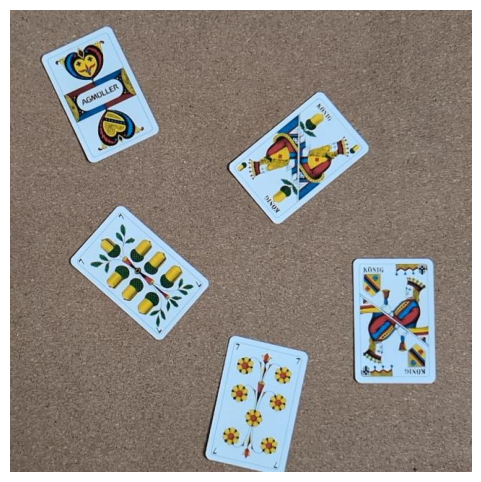

In [39]:
# Load a random test image and display it
test_image = random_test_image()
display_img(test_image, 6)

In [40]:
# Function for making a detection and classification with the loaded model
# conf = confidence threshold
def classify(model, conf, img):
    results = model(img, conf=conf)
    display_img(results[0].plot(), 6)


0: 640x640 1 eichel 7, 1 eichel 8, 1 eichel konig, 1 rose 7, 1 schilte ass, 1 schilte konig, 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


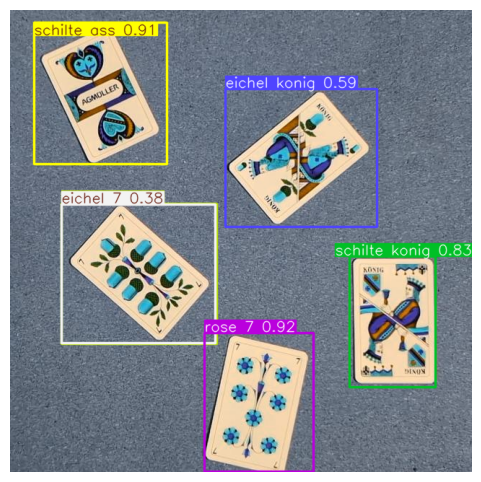

In [41]:
classify(model, 0.1, test_image)

### Automatic Evaluation on Testset

In [42]:
model.val(data='/exchange/dspro2/jassair/r_1to9_36c_novlp/data.yaml', split='test')

Ultralytics 8.3.108 🚀 Python-3.12.9 torch-2.6.0+cu124 CUDA:0 (NVIDIA A16, 14891MiB)


val: Scanning /exchange/dspro2/jassair/r_1to9_36c_novlp/test/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 2420.81it/s]

val: New cache created: /exchange/dspro2/jassair/r_1to9_36c_novlp/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


                   all          5         21      0.857      0.693      0.931      0.794
              eichel 6          2          2          1          0      0.995      0.808
              eichel 7          1          1      0.236      0.472      0.497      0.448
              eichel 8          1          1          1          0      0.332      0.232
          eichel konig          1          1      0.957          1      0.995      0.895
           eichel ober          1          1      0.906          1      0.995      0.796
          eichel under          1          1          1          0      0.995      0.895
               rose 10          1          1      0.809          1      0.995      0.895
                rose 6          1          1          1          0      0.995      0.697
                rose 7          1          1      0.668          1      0.995      0.895
                rose 8          1          1      0.736          1      0.995      0.796
            rose unde

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  6,  7,  8,  9, 10, 11, 12, 17, 22, 23, 25, 29, 30, 32, 33])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe02458ae10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    